In [ ]:
#!pip install --upgrade gspread_dataframe

In [1]:
from gspread_dataframe import set_with_dataframe, get_as_dataframe

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()


import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

# Try to open the sheet, create it if it doesn't exist
sheet_name = "VR_GameOver_Sea_Labels"

try:
    sheet = gc.open(sheet_name).sheet1
    print(f"Opened existing sheet: {sheet_name}")
except gspread.SpreadsheetNotFound:
    sheet = gc.create(sheet_name).sheet1
    print(f"Created new sheet: {sheet_name}")

Mounted at /content/drive
Opened existing sheet: VR_GameOver_Sea_Labels


In [3]:
import glob
import json
import re
import pandas as pd

# --------- Config: Relevant Keywords ---------
RELEVANT_KEYWORDS = [
    "Player",
    "Hand",       # matches HandLeft, HandRight, HandTracker, etc.
    "Foot",       # matches FootLeft, FootRight
    "Head",
    "Elbow",      # matches ElbowLeft, ElbowRight
    "Spine",      # matches SpineBase, SpineMid, SpineShoulder
    "Knee",       # matches KneeLeft, KneeRight
    "Raft",
    "FiringPoint"
]

# --------- Helpers ---------
def get_id(entry: dict) -> str:
    """Extract stable string ID from datetime (no float conversion)."""
    return re.sub(r"[^\d]", "", entry.get("datetime", ""))

def _pos_to_xyz(pos):
    """Convert Position to (x, y, z) tuple or (None, None, None)."""
    if pos is None:
        return (None, None, None)
    if isinstance(pos, (list, tuple)) and len(pos) >= 3:
        return (pos[0], pos[1], pos[2])
    if isinstance(pos, dict):
        x = pos.get("x") or pos.get("X")
        y = pos.get("y") or pos.get("Y")
        z = pos.get("z") or pos.get("Z")
        return (x, y, z)
    return (None, None, None)

def _is_relevant(name: str) -> bool:
    """Check if object name contains any of the relevant keywords."""
    return any(keyword in name for keyword in RELEVANT_KEYWORDS)

# --------- Relevant Object Position Extraction ---------
def get_object_positions(entry: dict) -> dict:
    object_positions = {}
    for _, value in entry.get("values", {}).items():
        name = value.get("Name", "")
        if _is_relevant(name):
            x, y, z = _pos_to_xyz(value.get("LocalPosition"))
            object_positions[name] = (x, y, z)
    return object_positions

# --------- JSON Reading ---------
def read_json_data(path: str):
    entries = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
            except json.JSONDecodeError:
                continue
            entries.append({
                "ID": get_id(entry),
                "Objects": get_object_positions(entry),
            })
    return entries

# --------- Global ID Counter ---------
_global_id_counter = 1
def get_global_id():
    global _global_id_counter
    gid = _global_id_counter
    _global_id_counter += 1
    return gid

# --------- DataFrame Conversion ---------
def data_to_dataframe(data_entries):
    all_objs = sorted({obj for entry in data_entries for obj in entry["Objects"].keys()})
    records = []
    for entry in data_entries:
        record = {"GlobalID": str(get_global_id()), "EntryID": str(entry["ID"])}
        for obj in all_objs:
            record[f"{obj}_X"] = ""
            record[f"{obj}_Y"] = ""
            record[f"{obj}_Z"] = ""
        for obj, (x, y, z) in entry["Objects"].items():
            record[f"{obj}_X"] = "" if x is None else str(x)
            record[f"{obj}_Y"] = "" if y is None else str(y)
            record[f"{obj}_Z"] = "" if z is None else str(z)
        for label in ["Spatial", "Temporal", "Spatial_1", "Temporal_1", "Spatial_2", "Temporal_2"]:
            record[label] = ""
        records.append(record)
    return pd.DataFrame(records, dtype=str)

In [47]:
import glob
import json
import re
import pandas as pd

# --------- Config: Relevant Keywords ---------
RELEVANT_KEYWORDS = [
    "Player",
    "Hand",       # matches HandLeft, HandRight, HandTracker, etc.
    "Foot",       # matches FootLeft, FootRight
    "Head",
    "Elbow",      # matches ElbowLeft, ElbowRight
    "Spine",      # matches SpineBase, SpineMid, SpineShoulder
    "Knee",       # matches KneeLeft, KneeRight
    "Raft",
    "FiringPoint"
]

# --------- Helpers ---------
def get_id(entry: dict) -> str:
    """Extract stable string ID from datetime (no float conversion)."""
    return re.sub(r"[^\d]", "", entry.get("datetime", ""))

def _pos_to_xyz(pos):
    """Convert Position to (x, y, z) tuple or (None, None, None)."""
    if pos is None:
        return (None, None, None)
    if isinstance(pos, (list, tuple)) and len(pos) >= 3:
        return (pos[0], pos[1], pos[2])
    if isinstance(pos, dict):
        x = pos.get("x") or pos.get("X")
        y = pos.get("y") or pos.get("Y")
        z = pos.get("z") or pos.get("Z")
        return (x, y, z)
    return (None, None, None)

def _quat_to_xyzw(rot):
    """Convert quaternion to (x, y, z, w) or (None, None, None, None)."""
    if rot is None:
        return (None, None, None, None)
    if isinstance(rot, (list, tuple)) and len(rot) >= 4:
        return (rot[0], rot[1], rot[2], rot[3])
    if isinstance(rot, dict):
        x = rot.get("x") or rot.get("X")
        y = rot.get("y") or rot.get("Y")
        z = rot.get("z") or rot.get("Z")
        w = rot.get("w") or rot.get("W")
        return (x, y, z, w)
    return (None, None, None, None)

def _is_relevant(name: str) -> bool:
    """Check if object name contains any of the relevant keywords."""
    return any(keyword in name for keyword in RELEVANT_KEYWORDS)

# --------- Relevant Object Position Extraction ---------
def get_object_positions(entry: dict) -> dict:
    object_positions = {}
    for _, value in entry.get("values", {}).items():
        name = value.get("Name", "")
        if _is_relevant(name):
            x, y, z = _pos_to_xyz(value.get("LocalPosition"))
            object_positions[name] = (x, y, z)
    return object_positions

def get_firingpoint_rotation(entry: dict):
    """Return FiringPoint LocalRotation as (x, y, z, w); None if absent."""
    for _, value in entry.get("values", {}).items():
        if value.get("Name") == "FiringPoint":
            return _quat_to_xyzw(value.get("LocalRotation"))
    return (None, None, None, None)

# --------- JSON Reading ---------
def read_json_data(path: str):
    entries = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
            except json.JSONDecodeError:
                continue
            entries.append({
                "ID": get_id(entry),
                "Objects": get_object_positions(entry),
                "FiringRot": get_firingpoint_rotation(entry),  # <-- added
            })
    return entries

# --------- Global ID Counter ---------
_global_id_counter = 1
def get_global_id():
    global _global_id_counter
    gid = _global_id_counter
    _global_id_counter += 1
    return gid

# --------- DataFrame Conversion ---------
def data_to_dataframe(data_entries):
    all_objs = sorted({obj for entry in data_entries for obj in entry["Objects"].keys()})
    records = []
    for entry in data_entries:
        record = {"GlobalID": str(get_global_id()), "EntryID": str(entry["ID"])}
        for obj in all_objs:
            record[f"{obj}_X"] = ""
            record[f"{obj}_Y"] = ""
            record[f"{obj}_Z"] = ""
        for obj, (x, y, z) in entry["Objects"].items():
            record[f"{obj}_X"] = "" if x is None else str(x)
            record[f"{obj}_Y"] = "" if y is None else str(y)
            record[f"{obj}_Z"] = "" if z is None else str(z)

        # ---- ONLY FiringPoint rotation columns (added) ----
        qx, qy, qz, qw = entry.get("FiringRot", (None, None, None, None))
        record["FiringPoint_RotX"] = "" if qx is None else str(qx)
        record["FiringPoint_RotY"] = "" if qy is None else str(qy)
        record["FiringPoint_RotZ"] = "" if qz is None else str(qz)
        record["FiringPoint_RotW"] = "" if qw is None else str(qw)

        for label in ["Spatial", "Temporal", "Spatial_1", "Temporal_1", "Spatial_2", "Temporal_2"]:
            record[label] = ""
        records.append(record)
    return pd.DataFrame(records, dtype=str)

In [59]:
import glob
import json
import re
import pandas as pd

# --------- Config: Relevant Keywords ---------
RELEVANT_KEYWORDS = [
    "Player",
    "Hand",       # matches HandLeft, HandRight, HandTracker, etc.
    "Foot",       # matches FootLeft, FootRight
    "Head",
    "Elbow",      # matches ElbowLeft, ElbowRight
    "Spine",      # matches SpineBase, SpineMid, SpineShoulder
    "Knee",       # matches KneeLeft, KneeRight
    "Raft",
    "FiringPoint"
]

# --------- Helpers ---------
def get_id(entry: dict) -> str:
    """Extract stable string ID from datetime (no float conversion)."""
    return re.sub(r"[^\d]", "", entry.get("datetime", ""))

def _pos_to_xyz(pos):
    """Convert Position to (x, y, z) tuple or (None, None, None)."""
    if pos is None:
        return (None, None, None)
    if isinstance(pos, (list, tuple)) and len(pos) >= 3:
        return (pos[0], pos[1], pos[2])
    if isinstance(pos, dict):
        x = pos.get("x") or pos.get("X")
        y = pos.get("y") or pos.get("Y")
        z = pos.get("z") or pos.get("Z")
        return (x, y, z)
    return (None, None, None)

def _quat_to_xyzw(rot):
    """Convert quaternion to (x, y, z, w) or (None, None, None, None)."""
    if rot is None:
        return (None, None, None, None)
    if isinstance(rot, (list, tuple)) and len(rot) >= 4:
        return (rot[0], rot[1], rot[2], rot[3])
    if isinstance(rot, dict):
        x = rot.get("x") or rot.get("X")
        y = rot.get("y") or rot.get("Y")
        z = rot.get("z") or rot.get("Z")
        w = rot.get("w") or rot.get("W")
        return (x, y, z, w)
    return (None, None, None, None)

def _is_relevant(name: str) -> bool:
    """Check if object name contains any of the relevant keywords."""
    return any(keyword in name for keyword in RELEVANT_KEYWORDS)

# --------- Relevant Object Position Extraction ---------
def get_object_positions(entry: dict) -> dict:
    object_positions = {}
    for _, value in entry.get("values", {}).items():
        name = value.get("Name", "")

        if _is_relevant(name):
            # Use Position for FiringPoint, LocalPosition for others
            if name == "FiringPoint":
                x, y, z = _pos_to_xyz(value.get("Position"))
            else:
                x, y, z = _pos_to_xyz(value.get("LocalPosition"))

            object_positions[name] = (x, y, z)
    return object_positions

def get_firingpoint_rotation(entry: dict):
    """Return FiringPoint LocalRotation as (x, y, z, w); None if absent."""
    for _, value in entry.get("values", {}).items():
        if value.get("Name") == "FiringPoint":
            return _quat_to_xyzw(value.get("LocalRotation"))
    return (None, None, None, None)

# --------- JSON Reading ---------
def read_json_data(path: str):
    entries = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                entry = json.loads(line)
            except json.JSONDecodeError:
                continue
            entries.append({
                "ID": get_id(entry),
                "Objects": get_object_positions(entry),
                "FiringRot": get_firingpoint_rotation(entry),
            })
    return entries

# --------- Global ID Counter ---------
_global_id_counter = 1
def get_global_id():
    global _global_id_counter
    gid = _global_id_counter
    _global_id_counter += 1
    return gid

# --------- DataFrame Conversion ---------
def data_to_dataframe(data_entries):
    all_objs = sorted({obj for entry in data_entries for obj in entry["Objects"].keys()})
    records = []
    for entry in data_entries:
        record = {"GlobalID": str(get_global_id()), "EntryID": str(entry["ID"])}
        for obj in all_objs:
            record[f"{obj}_X"] = ""
            record[f"{obj}_Y"] = ""
            record[f"{obj}_Z"] = ""
        for obj, (x, y, z) in entry["Objects"].items():
            record[f"{obj}_X"] = "" if x is None else str(x)
            record[f"{obj}_Y"] = "" if y is None else str(y)
            record[f"{obj}_Z"] = "" if z is None else str(z)

        # ---- ONLY FiringPoint rotation columns ----
        qx, qy, qz, qw = entry.get("FiringRot", (None, None, None, None))
        record["FiringPoint_RotX"] = "" if qx is None else str(qx)
        record["FiringPoint_RotY"] = "" if qy is None else str(qy)
        record["FiringPoint_RotZ"] = "" if qz is None else str(qz)
        record["FiringPoint_RotW"] = "" if qw is None else str(qw)

        for label in ["Spatial", "Temporal", "Spatial_1", "Temporal_1", "Spatial_2", "Temporal_2"]:
            record[label] = ""
        records.append(record)
    return pd.DataFrame(records, dtype=str)

In [1]:
# df = data_to_dataframe(read_json_data("/content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/raw_data.json"))


# # Convert numeric cols to float for inspection
# numeric_cols = [c for c in df.columns if any(c.endswith(s) for s in ["_X", "_Y", "_Z"])]
# df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# # Show first few rows
# print(df.head(10))

# # Check variation for a few joints
# print(df[["HandL_X", "HandL_Y", "HandL_Z"]].head(20))
# print(df[["FootL_X", "FootL_Y", "FootL_Z"]].head(20))

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data (1).json'

In [64]:
import json
import pandas as pd

# ==== CONFIG ====
json_path = "/content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/raw_data.json"  # change path if needed

# ==== LOAD JSON ====
data_entries = []
with open(json_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            entry = json.loads(line)
        except json.JSONDecodeError:
            continue
        # Flatten: combine Name with LocalPosition/Position if present
        for obj_name, obj_data in entry.get("values", {}).items():
            row = {"ID": entry.get("datetime", "")}
            for key in ["LocalPosition","Position"]:
                if key in obj_data and isinstance(obj_data[key], (list, tuple)) and len(obj_data[key]) >= 3:
                    row[f"{obj_data['Name']}_{key}_X"] = obj_data[key][0]
                    row[f"{obj_data['Name']}_{key}_Y"] = obj_data[key][1]
                    row[f"{obj_data['Name']}_{key}_Z"] = obj_data[key][2]
            data_entries.append(row)

# ==== CONVERT TO DATAFRAME ====
df = pd.DataFrame(data_entries)

# ==== PRINT INFO ====
print(f"Total samples: {len(df)}\n")
for col in df.columns:
    unique_vals = df[col].nunique(dropna=False)
    print(f"{col}: {unique_vals} unique values")

Total samples: 4800

ID: 300 unique values
PlayerImage_LocalPosition_X: 2 unique values
PlayerImage_LocalPosition_Y: 114 unique values
PlayerImage_LocalPosition_Z: 114 unique values
PlayerImage_Position_X: 299 unique values
PlayerImage_Position_Y: 299 unique values
PlayerImage_Position_Z: 140 unique values
PlayerTransformEffect_LocalPosition_X: 2 unique values
PlayerTransformEffect_LocalPosition_Y: 2 unique values
PlayerTransformEffect_LocalPosition_Z: 2 unique values
PlayerTransformEffect_Position_X: 299 unique values
PlayerTransformEffect_Position_Y: 299 unique values
PlayerTransformEffect_Position_Z: 11 unique values
HandL_LocalPosition_X: 295 unique values
HandL_LocalPosition_Y: 295 unique values
HandL_LocalPosition_Z: 268 unique values
HandL_Position_X: 299 unique values
HandL_Position_Y: 299 unique values
HandL_Position_Z: 289 unique values
HandR_LocalPosition_X: 293 unique values
HandR_LocalPosition_Y: 293 unique values
HandR_LocalPosition_Z: 259 unique values
HandR_Position_X: 

In [18]:
# def plot_skeleton_on_ax(row, ax, floor_w=3.0, floor_d=3.0, debug=False):
#     # ---- Bones grouped by limb using JSON names ----
#     bone_groups = {
#         'spine': [
#             ('SpineBase', 'Head'),        # minimal spine we have
#         ],
#         'left_arm': [
#             ('ElbowL', 'HandL'),
#         ],
#         'right_arm': [
#             ('ElbowR', 'HandR'),
#         ],
#         'left_leg': [
#             ('SpineBase', 'KneeL'),
#             ('KneeL', 'FootL'),
#         ],
#         'right_leg': [
#             ('SpineBase', 'KneeR'),
#             ('KneeR', 'FootR'),
#         ],
#     }

#     limb_colors = {
#         'spine': 'blue',
#         'left_arm': 'cyan',
#         'right_arm': 'fuchsia',
#         'left_leg': 'red',
#         'right_leg': 'lime',
#     }

#     # ---- Parse joint coordinates from row (expects columns like HandL_X/Y/Z) ----
#     def _to_float(v):
#         try:
#             return float(v)
#         except Exception:
#             return None

#     # collect base names that have X/Y/Z
#     base_names = {}
#     for col in row.index:
#         if col.endswith('_X') or col.endswith('_Y') or col.endswith('_Z'):
#             base = col[:-2]  # strip _X/_Y/_Z
#             base_names.setdefault(base, {'X': None, 'Y': None, 'Z': None})
#             if col.endswith('_X'):
#                 base_names[base]['X'] = _to_float(row[col])
#             elif col.endswith('_Y'):
#                 base_names[base]['Y'] = _to_float(row[col])
#             elif col.endswith('_Z'):
#                 base_names[base]['Z'] = _to_float(row[col])

#     # keep only the names that the reader produces (no aliasing)
#     allowed = {
#         'SpineBase', 'Head',
#         'ElbowL', 'ElbowR',
#         'HandL', 'HandR',
#         'KneeL', 'KneeR',
#         'FootL', 'FootR',
#     }

#     joint_coords = {}
#     for name, comps in base_names.items():
#         if name in allowed and None not in (comps['X'], comps['Y'], comps['Z']):
#             joint_coords[name] = (comps['X'], comps['Y'], comps['Z'])

#     # ---- Scatter joints ----
#     connected_joints = {j for bones in bone_groups.values() for pair in bones for j in pair}
#     for name, (x, y, z) in joint_coords.items():
#         ax.scatter(x, y, z, color='blue', s=(12 if name in connected_joints else 8))
#         ax.text(x, y, z, name, color='black', fontsize=8, ha='center', va='bottom')

#     # ---- Draw bones ----
#     for limb, bones in bone_groups.items():
#         color = limb_colors[limb]
#         for j1, j2 in bones:
#             if j1 in joint_coords and j2 in joint_coords:
#                 x1, y1, z1 = joint_coords[j1]
#                 x2, y2, z2 = joint_coords[j2]
#                 ax.plot([x1, x2], [y1, y2], [z1, z2], color=color)

#     # ---- Floor marker (center between feet, y at lower foot) ----
#     if 'FootL' in joint_coords and 'FootR' in joint_coords:
#         (lx, ly, lz) = joint_coords['FootL']
#         (rx, ry, rz) = joint_coords['FootR']
#         floor_x = (lx + rx) / 2.0
#         floor_y = min(ly, ry)
#         floor_z = (lz + rz) / 2.0
#     elif 'SpineBase' in joint_coords:
#         floor_x, floor_y, floor_z = joint_coords['SpineBase']
#     else:
#         floor_x = floor_y = floor_z = None

#     if floor_x is not None:
#         x_min, x_max = floor_x - floor_w, floor_x + floor_w
#         z_min, z_max = floor_z - floor_d, floor_z + floor_d
#         ax.plot([x_min, x_max, x_max, x_min, x_min],
#                 [floor_y] * 5,
#                 [z_min, z_min, z_max, z_max, z_min],
#                 color='purple', alpha=0.6)
#         ax.scatter(floor_x, floor_y, floor_z, color='red', s=40, marker='x')

#     # axes labels
#     ax.set_xlabel("X")
#     ax.set_ylabel("Y")
#     ax.set_zlabel("Z")

In [27]:
# def plot_skeleton_on_ax(row, ax, floor_w=3.0, floor_d=3.0, label_offset=0.15, debug=False):
#     # ---- bones (unchanged) ----
#     bone_groups = {
#         'spine': [('SpineBase', 'Head')],
#         'left_arm': [('ElbowL', 'HandL')],
#         'right_arm': [('ElbowR', 'HandR')],
#         'left_leg': [('SpineBase', 'KneeL'), ('KneeL', 'FootL')],
#         'right_leg': [('SpineBase', 'KneeR'), ('KneeR', 'FootR')],
#     }
#     limb_colors = {'spine':'blue','left_arm':'cyan','right_arm':'fuchsia','left_leg':'red','right_leg':'lime'}

#     # ---- parse joints (unchanged) ----
#     def _to_float(v):
#         try: return float(v)
#         except: return None

#     base_names = {}
#     for col in row.index:
#         if col.endswith(('_X','_Y','_Z')):
#             base = col[:-2]
#             base_names.setdefault(base, {'X':None,'Y':None,'Z':None})
#             if col.endswith('_X'): base_names[base]['X'] = _to_float(row[col])
#             if col.endswith('_Y'): base_names[base]['Y'] = _to_float(row[col])
#             if col.endswith('_Z'): base_names[base]['Z'] = _to_float(row[col])

#     allowed = {'SpineBase','Head','ElbowL','ElbowR','HandL','HandR','KneeL','KneeR','FootL','FootR'}
#     joint_coords = {n:(c['X'],c['Y'],c['Z']) for n,c in base_names.items()
#                     if n in allowed and None not in (c['X'],c['Y'],c['Z'])}

#     # ---- scatter + labels (labels float above by label_offset in Y) ----
#     connected = {j for bones in bone_groups.values() for a,b in bones for j in (a,b)}
#     for name, (x,y,z) in joint_coords.items():
#         ax.scatter(x, y, z, color='blue', s=(12 if name in connected else 8))
#         ax.text(x, y + label_offset, z, name, color='black', fontsize=8,
#                 ha='center', va='bottom')

#     # ---- draw bones (unchanged) ----
#     for limb, bones in bone_groups.items():
#         color = limb_colors[limb]
#         for j1, j2 in bones:
#             if j1 in joint_coords and j2 in joint_coords:
#                 x1,y1,z1 = joint_coords[j1]; x2,y2,z2 = joint_coords[j2]
#                 ax.plot([x1,x2],[y1,y2],[z1,z2], color=color)

#     floor_y = _to_float(row.get('Raft_Y'))
#     floor_x = _to_float(row.get('Raft_X'))
#     floor_z = _to_float(row.get('Raft_Z'))

#     if floor_x is not None:
#         x_min, x_max = floor_x - floor_w, floor_x + floor_w
#         z_min, z_max = floor_z - floor_d, floor_z + floor_d
#         ax.plot([x_min, x_max, x_max, x_min, x_min],
#                 [floor_y]*5,
#                 [z_min, z_min, z_max, z_max, z_min],
#                 color='orange', alpha=0.6)
#         ax.scatter(floor_x, floor_y, floor_z, color='red', s=40, marker='x')

#     ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

In [4]:
def plot_skeleton_on_ax(row, ax, label_offset=0.25, debug=False):
    # ---- bones (unchanged) ----
    bone_groups = {
        'spine': [('SpineBase', 'Head')],
        'left_arm': [('ElbowL', 'HandL')],
        'right_arm': [('ElbowR', 'HandR')],
        'left_leg': [('SpineBase', 'KneeL'), ('KneeL', 'FootL')],
        'right_leg': [('SpineBase', 'KneeR'), ('KneeR', 'FootR')],
    }
    limb_colors = {'spine':'blue','left_arm':'cyan','right_arm':'fuchsia','left_leg':'red','right_leg':'lime'}

    def _to_float(v):
        try: return float(v)
        except: return None

    # ---- parse joints ----
    base_names = {}
    for col in row.index:
        if col.endswith(('_X','_Y','_Z')):
            base = col[:-2]
            base_names.setdefault(base, {'X':None,'Y':None,'Z':None})
            if col.endswith('_X'): base_names[base]['X'] = _to_float(row[col])
            if col.endswith('_Y'): base_names[base]['Y'] = _to_float(row[col])
            if col.endswith('_Z'): base_names[base]['Z'] = _to_float(row[col])

    allowed = {'SpineBase','Head','ElbowL','ElbowR','HandL','HandR','KneeL','KneeR','FootL','FootR'}
    joint_coords = {n:(c['X'],c['Y'],c['Z']) for n,c in base_names.items()
                    if n in allowed and None not in (c['X'],c['Y'],c['Z'])}

    # ---- scatter + labels ----
    connected = {j for bones in bone_groups.values() for a,b in bones for j in (a,b)}
    for name, (x,y,z) in joint_coords.items():
        ax.scatter(x, y, z, color='blue', s=(12 if name in connected else 8))
        ax.text(x, y + label_offset, z, name, color='gray', fontsize=8, ha='center', va='bottom')

    # ---- draw bones ----
    for limb, bones in bone_groups.items():
        color = limb_colors[limb]
        for j1, j2 in bones:
            if j1 in joint_coords and j2 in joint_coords:
                x1,y1,z1 = joint_coords[j1]; x2,y2,z2 = joint_coords[j2]
                ax.plot([x1,x2],[y1,y2],[z1,z2], color=color)

    # ---- floor sized by Raft scale ----

    floor_y = _to_float(row.get('Raft_Y'))
    floor_x = _to_float(row.get('Raft_X'))
    floor_z = _to_float(row.get('Raft_Z'))

    # Half-extents from Raft scale (fallback to 3.5, 1.0 if absent)
    raft_scale_x = (
        _to_float(row.get('Raft_LocalScale_X')) or
        _to_float(row.get('Raft_ScaleX')) or
        3.5
    )
    raft_scale_z = (
        _to_float(row.get('Raft_LocalScale_Z')) or
        _to_float(row.get('Raft_ScaleZ')) or
        1.0
    )
    floor_w = raft_scale_x     # half-width in X
    floor_d = raft_scale_z     # half-depth in Z

    if floor_x is not None and floor_y is not None and floor_z is not None:
        x_min, x_max = floor_x - floor_w, floor_x + floor_w
        z_min, z_max = floor_z - floor_d, floor_z + floor_d
        ax.plot([x_min, x_max, x_max, x_min, x_min],
                [floor_y]*5,
                [z_min, z_min, z_max, z_max, z_min],
                color='orange', alpha=0.6)
        ax.scatter(floor_x, floor_y, floor_z, color='red', s=40, marker='x')

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

In [23]:
def plot_skeleton_on_ax(row, ax, label_offset=0.25, debug=False):
    # ---- bones (unchanged) ----
    bone_groups = {
        'spine': [('SpineBase', 'Head')],
        'left_arm': [('ElbowL', 'HandL')],
        'right_arm': [('ElbowR', 'HandR')],
        'left_leg': [('SpineBase', 'KneeL'), ('KneeL', 'FootL')],
        'right_leg': [('SpineBase', 'KneeR'), ('KneeR', 'FootR')],
    }
    limb_colors = {'spine':'blue','left_arm':'cyan','right_arm':'fuchsia','left_leg':'red','right_leg':'lime'}

    def _to_float(v):
        try: return float(v)
        except: return None

    # ---- parse joints ----
    base_names = {}
    for col in row.index:
        if col.endswith(('_X','_Y','_Z')):
            base = col[:-2]
            base_names.setdefault(base, {'X':None,'Y':None,'Z':None})
            if col.endswith('_X'): base_names[base]['X'] = _to_float(row[col])
            if col.endswith('_Y'): base_names[base]['Y'] = _to_float(row[col])
            if col.endswith('_Z'): base_names[base]['Z'] = _to_float(row[col])

    allowed = {'SpineBase','Head','ElbowL','ElbowR','HandL','HandR','KneeL','KneeR','FootL','FootR'}
    joint_coords = {n:(c['X'],c['Y'],c['Z']) for n,c in base_names.items()
                    if n in allowed and None not in (c['X'],c['Y'],c['Z'])}

    # ---- scatter + labels ----
    connected = {j for bones in bone_groups.values() for a,b in bones for j in (a,b)}
    for name, (x,y,z) in joint_coords.items():
        ax.scatter(x, y, z, color='blue', s=(12 if name in connected else 8))
        ax.text(x, y + label_offset, z, name, color='gray', fontsize=8, ha='center', va='bottom')

    # ---- draw bones ----
    for limb, bones in bone_groups.items():
        color = limb_colors[limb]
        for j1, j2 in bones:
            if j1 in joint_coords and j2 in joint_coords:
                x1,y1,z1 = joint_coords[j1]; x2,y2,z2 = joint_coords[j2]
                ax.plot([x1,x2],[y1,y2],[z1,z2], color=color)

    # ---- floor sized by Raft scale ----

    floor_y = _to_float(row.get('Raft_Y'))
    floor_x = _to_float(row.get('Raft_X'))
    floor_z = _to_float(row.get('Raft_Z'))

    # ---- raft box sized by Unity scale ----
    # NOTE: we treat the scale numbers as HALF-EXTENTS (to match your prior visuals).
    raft_scale_x = (
        _to_float(row.get('Raft_LocalScale_X')) or
        _to_float(row.get('Raft_ScaleX')) or
        3.5
    )
    raft_scale_z = (
        _to_float(row.get('Raft_LocalScale_Z')) or
        _to_float(row.get('Raft_ScaleZ')) or
        3.5
    )
    raft_scale_y = (
        _to_float(row.get('Raft_LocalScale_Y')) or
        _to_float(row.get('Raft_ScaleY')) or
        1.0   # reasonable default half-thickness
    )

    floor_w = raft_scale_x      # half-width in X
    floor_d = raft_scale_z      # half-depth in Z
    half_thick = raft_scale_y   # half-thickness in Y

    if floor_x is not None and floor_y is not None and floor_z is not None:
        # Top face at floor_y; bottom face below by 2*half_thick
        y_top = floor_y
        y_bot = floor_y - 2.0 * half_thick

        x_min, x_max = floor_x - floor_w, floor_x + floor_w
        z_min, z_max = floor_z - floor_d, floor_z + floor_d

        # 8 corners of the box
        v000 = (x_min, y_bot, z_min)
        v001 = (x_min, y_bot, z_max)
        v010 = (x_min, y_top, z_min)
        v011 = (x_min, y_top, z_max)
        v100 = (x_max, y_bot, z_min)
        v101 = (x_max, y_bot, z_max)
        v110 = (x_max, y_top, z_min)
        v111 = (x_max, y_top, z_max)

        # Faces (each as list of 3D points)
        faces = [
            [v010, v110, v111, v011],  # top
            [v000, v001, v101, v100],  # bottom
            [v000, v010, v011, v001],  # left
            [v100, v101, v111, v110],  # right
            [v000, v100, v110, v010],  # front
            [v001, v011, v111, v101],  # back
        ]

        try:
            from mpl_toolkits.mplot3d.art3d import Poly3DCollection
            poly = Poly3DCollection(faces, alpha=0.2, facecolor='orange', edgecolor='orange', linewidths=0.8)
            ax.add_collection3d(poly)
        except Exception:
            # Fallback: draw only the top rectangle + edges if Poly3DCollection is unavailable
            ax.plot([x_min, x_max, x_max, x_min, x_min],
                    [y_top]*5,
                    [z_min, z_min, z_max, z_max, z_min],
                    color='orange', alpha=0.6)
            # vertical edges
            for (x,z) in [(x_min,z_min), (x_min,z_max), (x_max,z_min), (x_max,z_max)]:
                ax.plot([x, x], [y_bot, y_top], [z, z], color='orange', alpha=0.6)

        # mark raft center
        ax.scatter(floor_x, y_top, floor_z, color='red', s=40, marker='x')

In [21]:
#####################HERE##########################

In [13]:
import os
import re
import shutil
import matplotlib.pyplot as plt

def _safe_name(s: str) -> str:
    s = str(s)
    return re.sub(r'[^A-Za-z0-9_\-]+', '', s)[:64]  # trim & sanitize

def save_skeleton_views_and_upload(row, output_dir_drive_path):
    # Make sure EntryID is a safe string
    entry_id = _safe_name(row['EntryID'])

    # Your standard: default view + two fixed views
    view_configs = [
        ('view1', 20, 20),     # "default-ish" (you can set whatever you like here)
        ('view2', -90, 90),    # top-down
        ('view3', 0, 20),      # front-iso
    ]

    uploaded_file_paths = []

    # Local temp folder
    local_tmp_dir = "/content/tmp_plots"
    os.makedirs(local_tmp_dir, exist_ok=True)

    # Ensure Drive base path exists
    drive_base = "/content/drive/MyDrive"
    final_dir = os.path.normpath(os.path.join(drive_base, output_dir_drive_path))
    os.makedirs(final_dir, exist_ok=True)

    for view_name, elev, azim in view_configs:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=elev, azim=azim)

        # Uses your UPDATED plotter for the new game
        plot_skeleton_on_ax(row, ax)

        fig.tight_layout()
        filename = f"{entry_id}_{view_name}.png"
        local_path = os.path.join(local_tmp_dir, filename)
        fig.savefig(local_path, dpi=150)
        plt.close(fig)

        final_path = os.path.join(final_dir, filename)
        shutil.move(local_path, final_path)
        uploaded_file_paths.append(final_path)

    return uploaded_file_paths

## Spartial View

In [25]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- bring these from your updated modules ---
# read_json_data(...)      # new version that filters by RELEVANT_KEYWORDS (Player/Hand/Foot/Head/Elbow/Spine/Knee/Raft/FiringPoint)
# data_to_dataframe(...)   # new version that keeps IDs as strings and consistent cols
# plot_skeleton_on_ax(...) # new PlayerJoints-based plotter

def _safe_name(s: str) -> str:
    s = str(s)
    return re.sub(r'[^A-Za-z0-9_\-]+', '', s)[:64]

def generate_data_and_plots_for_all_folders(root_path, json_filename='raw_data.json'):
    if not os.path.isdir(root_path):
        print(f"Root path not found: {root_path}")
        return

    for folder_name in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder_name)
        if not os.path.isdir(folder_path):
            continue

        json_path = os.path.join(folder_path, json_filename)
        plot_log_path = os.path.join(folder_path, 'plot_log')
        os.makedirs(plot_log_path, exist_ok=True)

        if os.path.exists(json_path):
            print(f"📂 Processing: {folder_name}")
            data = read_json_data(json_path)       # <-- new game extractor
            df = data_to_dataframe(data)           # <-- consistent cols, string IDs

            # Save CSV
            csv_path = os.path.join(folder_path, 'skeleton_data.csv')
            df.to_csv(csv_path, index=False)

            # Generate plots
            view_configs = [
                ('view1', 20, -60),
                ('view2', -90, 90),
                ('view3', 0, 20),
            ]

            for _, row in df.iterrows():
                entry_id = _safe_name(row['EntryID'])
                for view_name, elev, azim in view_configs:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    ax.view_init(elev=elev, azim=azim)
                    plot_skeleton_on_ax(row, ax)    # <-- new PlayerJoints plotter
                    plt.tight_layout()
                    fig.savefig(os.path.join(plot_log_path, f"{entry_id}_{view_name}.png"), dpi=150)
                    plt.close(fig)

# Point to the new game root
generate_data_and_plots_for_all_folders('/content/drive/MyDrive/VR_GameOver_Sea')

📂 Processing: gameover_sea01


📂 Processing: gameover_sea01


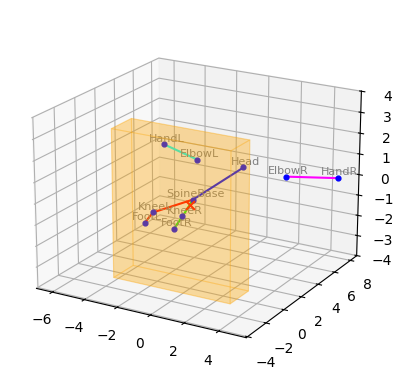

✅ Saved: /content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/plot_log/08062025071102988_view1.png


<Figure size 640x480 with 0 Axes>

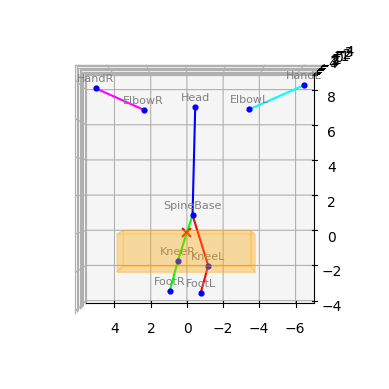

✅ Saved: /content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/plot_log/08062025071102988_view2.png


<Figure size 640x480 with 0 Axes>

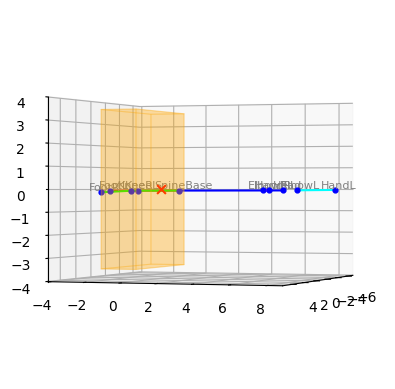

✅ Saved: /content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/plot_log/08062025071102988_view3.png


<Figure size 640x480 with 0 Axes>

In [24]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

# Assumes you've already updated these for the new game:
# read_json_data(...)      # uses RELEVANT_KEYWORDS (Player/Hand/Foot/Head/Elbow/Spine/Knee/Raft/FiringPoint)
# data_to_dataframe(...)   # keeps IDs as strings + consistent columns
# plot_skeleton_on_ax(...) # PlayerJoints-based plotter

def _safe_name(s: str) -> str:
    s = str(s)
    return re.sub(r'[^A-Za-z0-9_\-]+', '', s)[:64]

def generate_missing_views_for_entry(root_path, folder_name, target_entry_id, json_filename='raw_data.json'):
    folder_path = os.path.join(root_path, folder_name)
    json_path = os.path.join(folder_path, json_filename)
    plot_log_path = os.path.join(folder_path, 'plot_log')
    os.makedirs(plot_log_path, exist_ok=True)

    if not os.path.exists(json_path):
        print(f"❌ JSON not found: {json_path}")
        return

    print(f"📂 Processing: {folder_name}")
    data = read_json_data(json_path)
    df = data_to_dataframe(data)

    # Ensure string compare, since EntryID is stored as a string of digits
    target_entry_id = str(target_entry_id)
    row = df[df["EntryID"] == target_entry_id]
    if row.empty:
        print(f"❌ EntryID {target_entry_id} not found in {folder_name}")
        # Helpful hint: show a couple nearby IDs if you want:
        # print(df['EntryID'].head())
        return
    row = row.iloc[0]

    view_configs = [
        ('view1', 20, -60),
        ('view2', -90, 90),
        ('view3', 0, 20),   # add back the third view if you want it
    ]

    safe_id = _safe_name(target_entry_id)
    for view_name, elev, azim in view_configs:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=elev, azim=azim)
        plot_skeleton_on_ax(row, ax)  # <-- uses your updated PlayerJoints plotter
        plt.show()
        plt.tight_layout()
        save_path = os.path.join(plot_log_path, f"{safe_id}_{view_name}.png")
        fig.savefig(save_path, dpi=150)
        plt.close(fig)
        print(f"✅ Saved: {save_path}")

# Example run for the new game
generate_missing_views_for_entry(
    root_path='/content/drive/MyDrive/VR_GameOver_Sea',
    folder_name='gameover_sea01',               # <- update to your actual folder
    target_entry_id='08062025071102988',    # <- the exact digits-only ID
    json_filename='raw_data.json'           # <- change if different
)

In [13]:
data = read_json_data('/content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/raw_data.json')

# Print the first entry in full
import json
print(json.dumps(data[0], indent=2))

{
  "ID": "08062025071039871",
  "Objects": {
    "PlayerImage": [
      0,
      0,
      2.552
    ],
    "PlayerTransformEffect": [
      0,
      1,
      2.472
    ],
    "HandL": [
      0,
      0,
      2.552
    ],
    "HandR": [
      0,
      0,
      2.552
    ],
    "FootR": [
      0,
      0,
      2.552
    ],
    "FootL": [
      0,
      0,
      2.552
    ],
    "Head": [
      0,
      0,
      2.552
    ],
    "ElbowL": [
      0,
      0,
      2.552
    ],
    "ElbowR": [
      0,
      0,
      2.552
    ],
    "SpineBase": [
      0,
      0,
      2.552
    ],
    "KneeL": [
      0,
      0,
      2.552
    ],
    "KneeR": [
      0,
      0,
      2.552
    ],
    "Player": [
      0,
      0,
      2.552
    ],
    "RaftBack": [
      -4.731,
      0.357,
      0.1
    ],
    "Raft": [
      -4.5,
      0,
      0
    ],
    "FiringPoint": [
      11.184,
      0.63,
      0
    ]
  }
}


## Interactive View

In [95]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def quaternion_to_rotation_matrix(qx, qy, qz, qw):
    return R.from_quat([qx, qy, qz, qw]).as_matrix()

def _get_vec(row, base):
    try:
        x = float(row[f'{base}_X'])
        y = float(row[f'{base}_Y'])
        z = float(row[f'{base}_Z'])

        # Special case: add +2 offset to Y for FiringPoint
        if base == 'FiringPoint':
            y += 2.0

        return np.array([x, y, z], dtype=float)
    except Exception:
        return None

def _get_quat(row, base):
    """
    Try multiple naming schemes:
    - base_RotX, base_RotY, base_RotZ, base_RotW
    - base_Rotation_X, ... (if you expanded 'Rotation' array)
    - base_Rotation_0..3
    """
    keys = [
        (f'{base}_RotX', f'{base}_RotY', f'{base}_RotZ', f'{base}_RotW')
    ]
    for kx, ky, kz, kw in keys:
        try:
            return (float(row[kx]), float(row[ky]), float(row[kz]), float(row[kw]))
        except Exception:
            pass
    return None

def _draw_ray(ax, origin, direction, length=4.0, **kwargs):
    end = origin + direction * length
    ax.plot([origin[0], end[0]],
            [origin[1], end[1]],
            [origin[2], end[2]], **kwargs)
    return end

def draw_bullet_trajectory(row, ax, length=6.0, color='red', linewidth=2):
    """
    Draw a straight bullet trajectory from FiringPoint.
    Priority for direction:
      1) FiringPoint quaternion  (bullet goes along local -X)
      2) Gun/EnemyGun quaternion (if FiringPoint rot not available)
      3) LookTowards - FiringPoint (vector toward target)
    """
    fp = _get_vec(row, 'FiringPoint')
    if fp is None or not np.all(np.isfinite(fp)):
        return  # no start, nothing to draw

    # 1) Try FiringPoint rotation
    q = _get_quat(row, 'FiringPoint')

    Rm = quaternion_to_rotation_matrix(*q)
    dir_world = -(Rm @ np.array([1.0, 0.0, 0.0]))  # bullet moves along local -X

    _draw_ray(ax, fp, dir_world, length=length, color=color, linewidth=linewidth, alpha=0.5)
    ax.scatter(*fp, s=50, marker='^', color=color, alpha=0.5)
    ax.text(fp[0], fp[1]+ 0.2, fp[2], "FiringPoint", fontsize=8, color=color, alpha=0.5)

def plot_skeleton_interaction_on_ax(row, ax):
    """
    VR_GameOver_Sea interactive view:
    - Draw the skeleton using your updated plot_skeleton_on_ax (PlayerJoints joints).
    - Overlay FiringPoint and Bullet (optional Raft) with orientation rays if quaternion columns exist.
    - Auto-frame axes around skeleton + interaction objects.
    """
    # 1) Draw the skeleton just like the spatial view
    plot_skeleton_on_ax(row, ax)

    # 2) Overlay interaction objects
    plotted_points = []

    # Firing point
    draw_bullet_trajectory(row, ax, color='purple', length=8.0, linewidth=2)

In [97]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# assumes read_json_data(), data_to_dataframe(), plot_skeleton_interaction_on_ax() already exist

def _safe_name(s: str) -> str:
    s = str(s)
    return re.sub(r'[^A-Za-z0-9_\-]+', '', s)[:64]

def generate_interaction_data_and_plots_for_all_folders(
    root_path,
    json_filename='raw_data.json',
    show=False,
    dpi=150,
    views=None
):
    """
    Walks each subfolder of root_path, loads <json_filename>, writes CSV, and
    saves 3D interaction plots for every EntryID under plot_log/.

    Params
    ------
    root_path : str
    json_filename : str
        Default 'raw_data.json'
    show : bool
        If True, calls plt.show() for each plot (slow for big batches).
    dpi : int
        PNG export DPI.
    views : list[tuple[str,int,int]]
        Optional list of (view_name, elev, azim). If None, uses default trio.
    """
    if views is None:
        views = [
            ('view1', 20, -60),
            ('view2', -90, 90),
            ('view3', 0, 20),
        ]

    for folder_name in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder_name)
        if not os.path.isdir(folder_path):
            continue

        json_path = os.path.join(folder_path, json_filename)
        plot_log_path = os.path.join(folder_path, 'plot_log')
        os.makedirs(plot_log_path, exist_ok=True)

        if not os.path.exists(json_path):
            # skip folders without the json; keep silent or print a hint if you prefer
            # print(f"⏭️  Skipping (no JSON): {folder_name}")
            continue

        print(f"📂 Processing interactive view for: {folder_name}")

        # read + tabularize
        try:
            data = read_json_data(json_path)
            df = data_to_dataframe(data)
        except Exception as e:
            print(f"❌ Failed reading/parsing {json_path}: {e}")
            continue

        # Save CSV (overwrite each time)
        try:
            csv_path = os.path.join(folder_path, 'skeleton_data.csv')
            df.to_csv(csv_path, index=False)
        except Exception as e:
            print(f"❌ Failed writing CSV for {folder_name}: {e}")

        # Generate plots for each entry
        for _, row in df.iterrows():
            entry_id = str(row.get('EntryID', 'unknown'))
            safe_id = _safe_name(entry_id)

            for view_name, elev, azim in views:
                try:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    ax.view_init(elev=elev, azim=azim)

                    # your interactive plotter
                    plot_skeleton_interaction_on_ax(row, ax)

                    if show:
                        plt.show()

                    plt.tight_layout()
                    save_path = os.path.join(
                        plot_log_path, f"{safe_id}_interaction_{view_name}.png"
                    )
                    fig.savefig(save_path, dpi=dpi)
                    plt.close(fig)
                except Exception as e:
                    print(f"❌ Failed plotting {folder_name}/{entry_id} [{view_name}]: {e}")
            print(f"✅ Done entry: {entry_id}")

# Example batch run
generate_interaction_data_and_plots_for_all_folders(
    root_path='/content/drive/MyDrive/VR_GameOver_Sea',
    json_filename='raw_data.json',
    show=False,
    dpi=150
)

📂 Processing interactive view for: gameover_sea01
✅ Done entry: 08062025071039871
✅ Done entry: 08062025071044823
✅ Done entry: 08062025071045188
✅ Done entry: 08062025071045481
✅ Done entry: 08062025071045724
✅ Done entry: 08062025071045954
✅ Done entry: 08062025071046152
✅ Done entry: 08062025071046361
✅ Done entry: 08062025071046563
✅ Done entry: 08062025071046752
✅ Done entry: 08062025071046958
✅ Done entry: 08062025071047159
✅ Done entry: 08062025071047366
✅ Done entry: 08062025071047549
✅ Done entry: 08062025071047746
✅ Done entry: 08062025071047956
✅ Done entry: 08062025071048159
✅ Done entry: 08062025071048353
✅ Done entry: 08062025071048559
✅ Done entry: 08062025071048759
✅ Done entry: 08062025071048952
✅ Done entry: 08062025071049149
✅ Done entry: 08062025071049363
✅ Done entry: 08062025071049563
✅ Done entry: 08062025071049761
✅ Done entry: 08062025071049953
✅ Done entry: 08062025071050159
✅ Done entry: 08062025071050349
✅ Done entry: 08062025071050553
✅ Done entry: 08062025

📂 Processing interactive view for: gameover_sea01


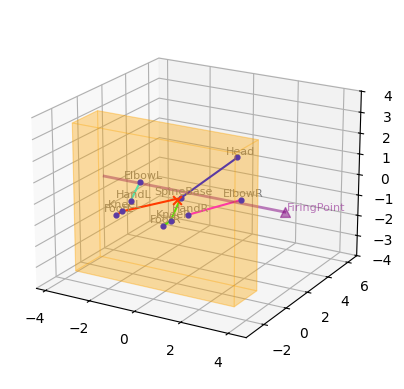

✅ Saved: /content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/plot_log/08062025071119185_interaction_view1.png


<Figure size 640x480 with 0 Axes>

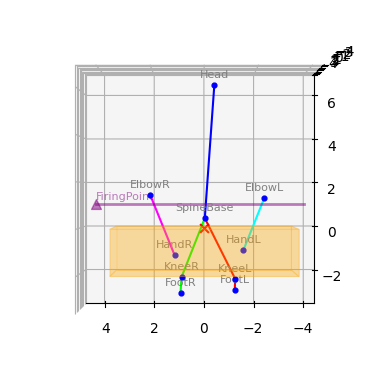

✅ Saved: /content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/plot_log/08062025071119185_interaction_view2.png


<Figure size 640x480 with 0 Axes>

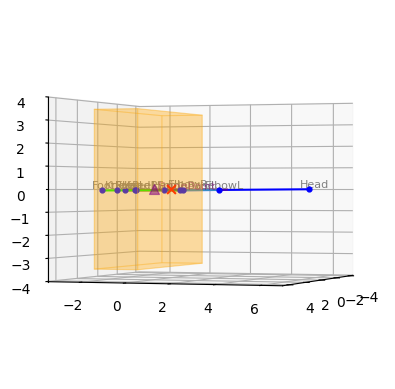

✅ Saved: /content/drive/MyDrive/VR_GameOver_Sea/gameover_sea01/plot_log/08062025071119185_interaction_view3.png


<Figure size 640x480 with 0 Axes>

In [96]:
import os
import re
import matplotlib.pyplot as plt

# assumes read_json_data(), data_to_dataframe(), plot_skeleton_interaction_on_ax() already exist

def _safe_name(s: str) -> str:
    s = str(s)
    return re.sub(r'[^A-Za-z0-9_\-]+', '', s)[:64]

def generate_interactive_views_for_entry(
    root_path,
    folder_name,
    target_entry_id,
    json_filename='raw_data.json',
    show=False,
    dpi=150
):
    folder_path = os.path.join(root_path, folder_name)
    json_path = os.path.join(folder_path, json_filename)
    plot_log_path = os.path.join(folder_path, 'plot_log')
    os.makedirs(plot_log_path, exist_ok=True)

    if not os.path.exists(json_path):
        print(f"❌ JSON not found: {json_path}")
        return

    print(f"📂 Processing interactive view for: {folder_name}")
    data = read_json_data(json_path)
    df = data_to_dataframe(data)

    target_entry_id = str(target_entry_id)
    row = df[df["EntryID"] == target_entry_id]
    if row.empty:
        print(f"❌ EntryID {target_entry_id} not found in {folder_name}")
        return
    row = row.iloc[0]

    view_configs = [
        ('view1', 20, -60),
        ('view2', -90, 90),
        ('view3', 0, 20),
    ]

    safe_id = _safe_name(target_entry_id)
    for view_name, elev, azim in view_configs:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=elev, azim=azim)

        # plot the interactive skeleton
        plot_skeleton_interaction_on_ax(row, ax)

        if show:
            plt.show()
        plt.tight_layout()

        save_path = os.path.join(plot_log_path, f"{safe_id}_interaction_{view_name}.png")
        fig.savefig(save_path, dpi=dpi)
        plt.close(fig)
        print(f"✅ Saved: {save_path}")

# Example run
generate_interactive_views_for_entry(
    root_path='/content/drive/MyDrive/VR_GameOver_Sea',
    folder_name='gameover_sea01',
    target_entry_id='08062025071119185',
    json_filename='raw_data.json',
    show=True,
    dpi=150
)

In [ ]:
pip install gspread oauth2client gspread_dataframe

In [ ]:
import os
import pandas as pd
import gspread
from google.colab import auth
from gspread_dataframe import set_with_dataframe
from google.auth import default
from googleapiclient.discovery import build

# Authenticate and set up services
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive_service = build('drive', 'v3', credentials=creds)

# --------- Helper Functions ---------
def get_folder_id_by_path(path_list):
    """Walk through the path to get the folder ID."""
    parent_id = 'root'
    for name in path_list:
        query = f"mimeType='application/vnd.google-apps.folder' and trashed = false and name='{name}' and '{parent_id}' in parents"
        results = drive_service.files().list(q=query, spaces='drive', fields="files(id, name)", pageSize=10).execute()
        items = results.get('files', [])
        if not items:
            raise FileNotFoundError(f"Folder '{name}' not found under parent ID '{parent_id}'")
        parent_id = items[0]['id']
    return parent_id

# def get_public_image_link(file_name, folder_id):
#     """Find the file in Drive, make it public, and return an IMAGE formula for Sheets."""
#     query = f"name='{file_name}' and '{folder_id}' in parents and trashed = false"
#     results = drive_service.files().list(q=query, fields="files(id, name)").execute()
#     items = results.get('files', [])
#     if not items:
#         return ""  # Skip if image not found

#     file_id = items[0]['id']

#     # Make it public
#     try:
#         drive_service.permissions().create(
#             fileId=file_id,
#             body={"role": "reader", "type": "anyone"},
#             fields="id"
#         ).execute()
#     except:
#         pass  # Permission might already exist

#     # Create direct image link
#     public_url = f"https://drive.google.com/uc?export=download&id={file_id}"
#     return f'=IMAGE("{public_url}")'

def get_public_image_link(file_name, folder_id):
    """Find the file in Drive, make it public, and return an IMAGE formula for Sheets."""
    query = f"name='{file_name}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])
    if not items:
        return ""  # Skip if image not found

    file_id = items[0]['id']

    # Make it public
    try:
        drive_service.permissions().create(
            fileId=file_id,
            body={"role": "reader", "type": "anyone"},
            fields="id"
        ).execute()
    except:
        pass  # Permission might already exist

    # Return formula for Sheets
    public_url = f"https://drive.google.com/uc?export=view&id={file_id}"
    return f'=IMAGE("{public_url}")'



# --------- Base Setup ---------
base_path = "/content/drive/MyDrive/VR_GameOver_Sea"
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# --------- Main Loop for Each Folder ---------
for folder in folders:
    print(f"📁 Processing folder: {folder}")
    try:
        # Get Google Drive folder IDs for plot_log and image_log
        plot_folder_id = get_folder_id_by_path(["VR_GameOver_Sea", folder, "plot_log"])
        image_folder_id = get_folder_id_by_path(["VR_GameOver_Sea", folder, "image_log"])
    except FileNotFoundError as e:
        print(f"⚠️ Skipping {folder}: {e}")
        continue

    # Get EntryIDs from plot_log view1 files
    local_plot_path = os.path.join(base_path, folder, "plot_log")
    entry_ids = sorted(set(
        fname.split('_')[0]
        for fname in os.listdir(local_plot_path)
        if fname.endswith('.png') and '_view1' in fname
    ))

    # Build dataframe
    records = []
    for entry_id in entry_ids:
        record = {
            "EntryID": entry_id,
            "view1": get_public_image_link(f"{entry_id}_view1.png", plot_folder_id),
            "view2": get_public_image_link(f"{entry_id}_view2.png", plot_folder_id),
            "view3": get_public_image_link(f"{entry_id}_view3.png", plot_folder_id),
            "Image": get_public_image_link(f"{entry_id}.png", image_folder_id),
            "Spatial 1": "", "Spatial 2": "", "Spatial": "",
            "interaction_view1": get_public_image_link(f"{entry_id}_interaction_view1.png", plot_folder_id),
            "interaction_view2": get_public_image_link(f"{entry_id}_interaction_view2.png", plot_folder_id),
            "interaction_view3": get_public_image_link(f"{entry_id}_interaction_view3.png", plot_folder_id),
            "image": get_public_image_link(f"{entry_id}.png", image_folder_id),
            "Temporal1": "", "Temporal2": "", "Temporal": ""
        }
        records.append(record)

    df = pd.DataFrame(records)

    # Create Google Sheet
    sheet_title = f"{folder}_LabelSheet"
    try:
        sh = gc.create(sheet_title)
        worksheet = sh.get_worksheet(0)
        set_with_dataframe(worksheet, df)
        print(f"✅ Created sheet: {sheet_title}")
    except Exception as e:
        print(f"❌ Failed to create sheet for {folder}: {e}")

📁 Processing folder: gameover_sea01
